In [1]:
import os
import sys
import time
import yaml
import pandas as pd
import numpy as np

with open('../../config.local.yaml', 'r') as f:
    local_config = yaml.safe_load(f)

LOCAL_PATH = local_config['LOCAL_PATH']

sys.path.append(os.path.join(LOCAL_PATH, "src/python"))

import data_tools as dt

from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from IPython.core.display import HTML
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from stargazer.stargazer import Stargazer

rng = np.random.default_rng(12898)

SUPPORT_TAGS = ['DEFINITELY SUPPORT', 'SOMEWHAT SUPPORT']
OPPOSE_TAGS = ['DEFINITELY OPPOSE', 'SOMEWHAT OPPOSE']
APPROVE_TAGS = ['APPROVED', 'APPROVED WITH MINOR CHANGES']


In [2]:
df = dt.get_supplemental_docs()

No proper response found for 2018-06-14, doc_id 1, pages 2-2


In [3]:
idx = df['support_or_oppose'].isin(SUPPORT_TAGS + OPPOSE_TAGS)
idx_support = df['support_or_oppose'].isin(SUPPORT_TAGS)
idx_oppose = df['support_or_oppose'].isin(OPPOSE_TAGS)

In [4]:
# Keep only documents that either support or oppose
df2 = df.loc[idx].reset_index(drop=True)

In [5]:
print("*** EXAMPLE OF A LETTER ROW ***")
df2.loc[0:1]

*** EXAMPLE OF A LETTER ROW ***


,year,date,doc_id,start_page,end_page,content,prompt,response,score,doc_type,author_type,summary,referenced_items,support_or_oppose
0,2018,2018-05-10,2,3,8,\n ...,\n==== LIST OF AGENDA ITEMS ====\n\nITEM NO. 5...,\n==== YOUR RESPONSE FORMAT ====\n\nTYPE OF DO...,-0.028656,LETTER OR PETITION,CONSULTANT,The document is a letter from Irvine & Associa...,6,DEFINITELY SUPPORT
1,2018,2018-05-10,7,175,176,\n ...,\n==== LIST OF AGENDA ITEMS ====\n\nITEM NO. 5...,==== YOUR RESPONSE FORMAT ====\n\nTYPE OF DOCU...,-0.391186,LETTER OR PETITION,ADVOCACY GROUP,The document is a letter from Abundant Housing...,"6, 7, 8, 9, 10",DEFINITELY SUPPORT


In [6]:
minutes_df = dt.get_minutes()

No data found for 2021-01-14
No data found for 2022-03-17
No data found for 2022-10-13


In [7]:
df3 = minutes_df.copy()

In [8]:
print("*** EXAMPLE OF A MINUTES ITEM ***")
df3.loc[0:1]

*** EXAMPLE OF A MINUTES ITEM ***


,year,date,item_no,title,prompt,response,score,related_cases,agenda_item_summary,deliberations_summary,motion_summary,votes_for,votes_against,votes_absent,vote_result,appeal_result,project_result
0,2018,2018-05-10,5a,CPC-2014-2906-TDR-SPR,\n--- AGENDA ITEM ----\n\n 5a. CPC-2014...,---- YOUR RESPONSE FORMAT ----\n\nRELATED CASE...,-0.000555,"CPC-2014-2906-TDR-SPR, ENV-2014-2907-MND, VTT-...",The agenda item concerns the proposed demoliti...,The City Planning Commission reviewed the proj...,Commissioner Millman proposed a motion to appr...,"Millman, Mitchell, Choe, Khorsand, Perlman, Da...",NONE,"Ambroz, Padilla-Campos",MOTION PASSED,NO APPEAL,APPROVED
1,2018,2018-05-10,6,DIR-2017-4872-TOC-1A,\n--- AGENDA ITEM ----\n\n 6. DIR-2017...,---- YOUR RESPONSE FORMAT ----\n\nRELATED CASE...,-0.000997,"DIR-2017-4872-TOC-1A, ENV-2017-4873-CE",The agenda item involves the proposed demoliti...,The City Planning Commission held a public hea...,The motion proposed by Commissioner Dake Wilso...,"Dake Wilson, Khorsand, Choe, Millman, Mitchell...",NONE,"Ambroz, Padilla-Campos",MOTION PASSED,APPEAL GRANTED IN PART,APPROVED WITH MINOR CHANGES


In [9]:
df3['n_support'] = 0
df3['n_oppose'] = 0
for idx, irow in df3.iterrows():
    date = irow['date']
    item_no = irow['item_no']
    for jdx, jrow in df2.loc[df2['date']==date].iterrows():
        referenced_items = [s.strip() for s in jrow['referenced_items'].split(',')]
        support_or_oppose = jrow['support_or_oppose']
        if item_no in referenced_items:
            df3.loc[idx, 'n_support'] += 1*(support_or_oppose in SUPPORT_TAGS)
            df3.loc[idx, 'n_oppose'] += 1*(support_or_oppose in OPPOSE_TAGS)

In [10]:
# Show distribution of outcomes
print("*** DISTRIBUTION OF MOTION OUTCOMES ***")
df3['project_result'].value_counts()

*** DISTRIBUTION OF MOTION OUTCOMES ***


project_result
APPROVED                                  333
APPROVED WITH MINOR CHANGES               269
DELIBERATIONS CONTINUED TO FUTURE DATE    112
DENIED                                     11
APPROVED WITH MAJOR CHANGES                 7
Name: count, dtype: int64

In [11]:
# Show distribution of support/oppose letters
print("*** DISTRIBUTION OF SUPPORT/OPPOSITION FOR LETTERS ***")
df2['support_or_oppose'].value_counts()

*** DISTRIBUTION OF SUPPORT/OPPOSITION FOR LETTERS ***


support_or_oppose
DEFINITELY OPPOSE     2132
DEFINITELY SUPPORT    1791
SOMEWHAT SUPPORT       308
SOMEWHAT OPPOSE        294
Name: count, dtype: int64

In [12]:
# Distribution of support or oppose 
print("*** DISTRIBUTION OF SUPPORT/OPPOSE BY AUTHOR TYPE ***")
pd.crosstab(df2['author_type'], df2['support_or_oppose'])

*** DISTRIBUTION OF SUPPORT/OPPOSE BY AUTHOR TYPE ***


support_or_oppose,DEFINITELY OPPOSE,DEFINITELY SUPPORT,SOMEWHAT OPPOSE,SOMEWHAT SUPPORT
author_type,,,,
ADVOCACY GROUP,296,329,74,91
CONSULTANT,35,112,16,15
DEVELOPER,2,56,4,9
INDIVIDUAL,1640,1050,166,156
LAWYER,146,124,23,18
OTHER,7,14,2,1
PUBLIC OFFICIAL,6,106,9,18


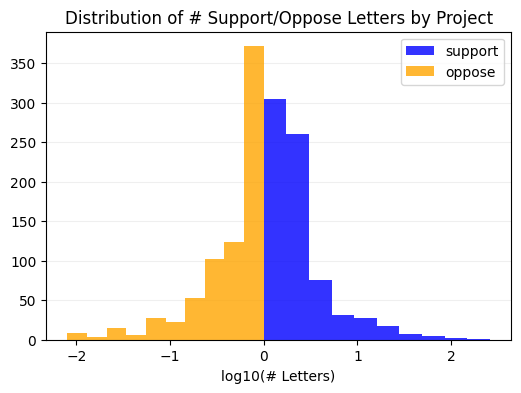

In [13]:
plt.figure(figsize=(6,4))
plt.hist(np.log10(df3['n_support']+1), alpha=0.8, color='blue', label='support')
plt.hist(-np.log10(df3['n_oppose']+1), alpha=0.8, color='orange', label='oppose')
plt.xlabel('log10(# Letters)')
plt.legend()
plt.grid(axis='y', alpha=0.2)
plt.gca().set_axisbelow(True)
plt.title("Distribution of # Support/Oppose Letters by Project")
plt.show()

In [14]:
df3['log2_support'] = np.log(df3['n_support']+1)/np.log(2)
df3['log2_oppose'] = np.log(df3['n_oppose']+1)/np.log(2)

approve_tags = ['APPROVED', 'APPROVED WITH MINOR CHANGES']
predictors = ['log2_support', 'log2_oppose']

y = df3['project_result'].isin(approve_tags)
X = sm.add_constant(df3[predictors])

model = sm.Logit(y, X).fit()

sg = Stargazer([model])
sg.title(title="Logit Regression: Success=Approve/Approve with Minor Changes")
HTML(sg.render_html())

Optimization terminated successfully.
         Current function value: 0.453977
         Iterations 6


In [15]:
params = model.params
np.exp(params)

const           4.961529
log2_support    1.321559
log2_oppose     0.736860
dtype: float64